In [5]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In time series analysis [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) class of models is the basis for signal modelling and prediction. It’s a well researched mathematical tool with strong theoretical background and decades of practical applications. ARIMA states for "Auto-Regressive Integrated Moving Average". This model consists of two parts - Auto-Regressive and Moving Average forming another state-of-art model [ARMA](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model), and "integrated" means, that modelled time-series is an integrated ARMA process, i. e. finite differences of the series are modelled by ARMA. One useful representation of ARMA is in form of lag operator polynomials. Adding integration to make an ARIMA from ARMA means multiplying the initial equation by finite difference operator which is also linear. This makes ARIMA a linear model. This is also true for SARIMA (seasonal ARIMA), because seasonal components are still represented as lag polynomials. But linearity doesn’t always hold in real world problems, more to say it is quite rare. There are a lot of real world processes which cannot be precisely described by linear systems. One common scenario is multi-regime operation, where systems switches between several states, which abruptly changes the dynamics of the modelled time series. Application of linear models in such situations leads to larger errors. But this is where neo-fuzzy neuron becomes handy.

Neo-fuzzy neuron (NFN) was initialy described in \[1\]. It have been around for 25 years already but haven't gain much popularity except from [fuzzy logic](https://en.wikipedia.org/wiki/Fuzzy_logic) specialists. It has some nice features though. The NFN has the following scheme:

image here

$$NFN(\vec x) = \sum_{i=1}^{n} f_i(x_i) = \sum_{i=1}^{n} \sum_{j=1}^{m} w_{ij} \mu_{ij}(x_i)$$

Here $f_i(x_i)$ are fuzzy inference rules with triangular membership functions (MFs):

$$\mu(x, a, m ,b) = \begin{cases} 
    0, & x \leq a \\ 
    \frac{x - a}{m - a}, & a < x \leq m \\
    \frac{b - x}{b - m}, & m < x \leq b \\
    0, & x > b \end{cases}$$

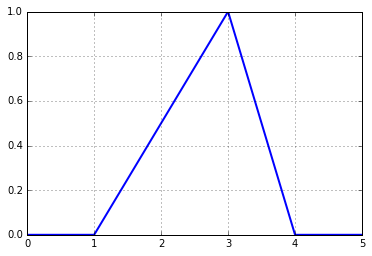

In [6]:
def triangular_mf(x, a, m, b):
    return np.maximum(0, np.minimum((x - a) / (m - a), (b - x) / (b - m)))

a = 1
m = 3
b = 4
x = np.linspace(a - 1, b + 1, (b - a + 2)*100)
plt.plot(x, triangular_mf(x, a, m, b), lw = 2)
plt.grid()

MFs in the inference rule must be complementary, so they add up to one in any point. Complementarity means, we can define a grid in the input domain, and this grid fully describes the collection of fuzzy sets in this space, so each MF depends only on it's center point $m$. 

In the original paper each inference rule $f_i(x_i)$ was a [Sugeno-type rule]() described in slightly different form:

$$f_i(x_i) = \sum_{j=1}^{m} w_{ij} \mu_(x_i, m_j)$$

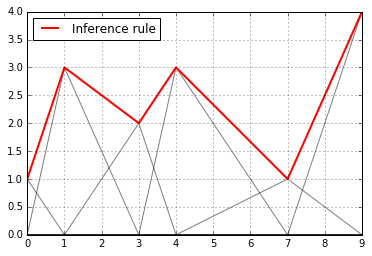

In [7]:
def get_asym_mfunc(grid):
    """
    Creates asymmetric triangular membership functions.
    
    Resulting function accepts batches of data. 

    Args
        grid (ndarray): non-uniform fuzzy partioning grid 

    Returns
        function: a batch processing function
    """

    _grid = grid.copy()

    a = _grid[None,  :-2, :]
    b = _grid[None, 1:-1, :]
    c = _grid[None, 2:  , :]
    
    p =  1 / (b - a)
    q = -a / (b - a)
    r = -1 / (c - b)
    s =  c / (c - b)
    
    def _mfunc(batch):
        X = batch[:,None,:]
        lmask = np.ravel((X >= a) & (X < b))
        rmask = np.ravel((X >= b) & (X < c))
        M = np.zeros(rmask.size)
        M[lmask] = np.ravel(p*X + q)[lmask]
        M[rmask] = np.ravel(r*X + s)[rmask]
        M = M.reshape((X.shape[0], a.shape[1], X.shape[2]))
        return M
    
    return _mfunc

# define a grid on the inteval [0;9] and create a set
# of complementary MFs. 

grid = [-1, 0, 1, 3, 4, 7, 9, 10]
w    = [    1, 3, 2, 3, 1, 4    ]
x = np.linspace(grid[1], grid[-2], (grid[-2] - grid[1])*100).reshape(-1,1)
mfunc = get_asym_mfunc(np.array([grid]).T)
M = mfunc(x)
W = np.array([w]).T
Y = W[None,:,:] * M

for i in range(M.shape[1]):
    plt.plot(x, Y[:,i,0], 'k-', alpha = 0.5)
plt.plot(x, Y.sum(axis = (1,2)), 'r-', lw = 2, label = 'Inference rule')
plt.legend(loc = 'best')
plt.grid()

Now let's look closer in this inference rule and how it's related to time series modelling. Let's consider a toy example where there is some time series $x(t)$ which is fully contained in the interval $[\alpha,\beta]$. Now we design a trivial neo-fuzzy neuron for one-step prediction of this time series with one inference rule having two logical terms:

$$\hat{x_t} = NFN(x_{t-1}) = f_1(x_{t-1}) = w_1 \mu(x_{t-1}, \alpha-\beta, \alpha, \beta) + w_2 \mu(x_{t-1}, \alpha, \beta, \beta + \alpha) = w_1 \mu_\alpha(x_{t-1}) + w_2 \mu_\beta(x_{t-1})$$

For all valid values of $x(t)$ from the interval $[\alpha, \beta]$ and triangular complementary MFs the inference function of this rule is a linear function:

$$f(x_{t-1}) = \frac{w_1 \beta - w_2 \alpha}{\beta - \alpha} + \frac{w_2 - w_1}{\beta - \alpha} x_{t-1} = a_0 + a_1 x_{t-1} $$

Adding a noise terms $\epsilon_t$ to this we get an exact description of the AR(1) process with parameters $a_0$ and $a_1$. It's trivial to show that this equivalence holds for any AR(p) process. So here we outlined a simple proof of equivalence of AR(p) models and NFNs. There is a subtle detail though. An AR(p) process has $p + 1$ free parameters, while it's equivalent NFN - $2 p$ parameters. Because of this, if we'd wanted to write down equations of AR(p) coefficients in terms of NFN weights, resulting systed would be ill-defined (there is an infinite set of equivalent NFNs), so some form of regularization would be needed.

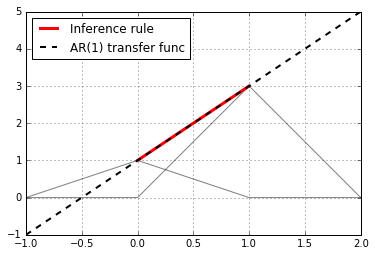

In [8]:
# construction of a trivial NFN and demonstration of 
# the equivalence to an AR(1) model

grid = [-1, 0, 1, 2]
w    = [    1, 3,  ]
x = np.linspace(grid[0], grid[-1], (grid[-1] - grid[0])*100).reshape(-1,1)
mfunc = get_asym_mfunc(np.array([grid]).T)
M = mfunc(x)
W = np.array([w]).T
Y = W[None,:,:] * M

for i in range(M.shape[1]):
    plt.plot(x, Y[:,i,0], 'k-', alpha = 0.5)
plt.plot(x[100:200], Y[100:200].sum(axis = (1,2)), 'r-', lw = 3, label = 'Inference rule')

a0 = (w[0]*grid[2] - w[1]*grid[1]) / (grid[2] - grid[1])
a1 = (w[1] - w[0]) / (grid[2] - grid[1])
plt.plot(x, a0 + a1*x, 'k--', lw = 2, label = 'AR(1) transfer func')
plt.legend(loc = 'best')
plt.grid()

Now we begin to get advantage from NFN and start adding parameters to inference rules. We divide the initial interval $[\alpha, \beta]$ into two parts, so we have a grid $[\alpha, \gamma, \beta]$ and our simple NFN will now have an inference rule with three logical terms:

$$NFN(x_{t-1}) = f_1(x_{t-1}) = w_1 \mu_\alpha(x_{t-1}) + w_2 \mu_\gamma(x_{t-1}) + w_3 \mu_\beta(x_{t-1})$$

Using the same method as before we try to find a corresponding AR(1) process to this:

$$f(x_{t-1}) = \begin{cases}
    \frac{w_1 \gamma - w_2 \alpha}{\gamma - \alpha} + \frac{w_2 - w_1}{\gamma - \alpha} x_{t-1} = a_{\alpha\gamma,0} + a_{\alpha\gamma,1} x_{t-1}, & \alpha < x \leq \gamma \\
    \frac{w_2 \beta - w_3 \gamma}{\beta - \gamma} + \frac{w_3 - w_2}{\beta - \gamma} x_{t-1} = a_{\gamma\beta,0} + a_{\gamma\beta,1} x_{t-1}, & \gamma < x \leq \beta
    \end{cases}$$

What we've got are two AR(1) processes for each section of the input domain. This means that NFN is switching between two linear models when input signal goes from $[\alpha,\gamma]$ to $(\gamma,\beta]$ and vice versa. When input signal stays in the first interval, an $AR_{[\alpha,\gamma]}(1)$ is applied, when it goes to the other interval, an $AR_{[\gamma,\beta]}(1)$ is applied. This can be seen as a piecewise linearization of the underlying non-linear complex dynamics. Generalization to an arbitrary number of logical terms per rule is straightforward. For $m$ terms we have a grid $c_1 < c_2 <... < c_m$ which divides an input space into $m-1$ disjoint intervals, so the equivalent NFN model becomes:

$$NFN_{p,m} = AR_{c_i,c_{i+1}}(p), x \in [c_i,c_{i+1}], i = 1..m-1$$

From the practical standpoint this means, that if we have a non-linear time series which can be models as a linear process on different parts of it's domain, NFN can be applied to this series and produce better results than ARIMA. Examples of such processes are CPU, memory and network load measurements, which have predefined range of value (0-100% load for CPU, RAM size for memory, 0-100 MiB/sec of network load) and their behaviour near these limits is different from mid-ranges. Another example is volt-ampere characteristics in some electric circuts with piecewise linear dynamics because of properties of semi-conductors. Yet another example is the change of water level of the river during rains: higher the water, shallower the regions of the banks if floods, so the rise slows down. 

In [60]:
# here is the short implementation of a neo-fuzzy neuron using 
# sklearn's linear solvers

from sklearn.linear_model import Ridge, Lasso
from copy import deepcopy


def uniform_grid(X, n_rules):
    """
    Generates a uniform grid from a set of input variables

    Args
        X (ndarray): row-based data matrix
        n_rules (int): number of fuzzy inference rules;
            the resulting grid has ``n_rules + 3`` points

    Returns
        ndarray: 2D-array of grid points per input variable

    Raises
        ValueError: if ``n_rules < 1``
    """

    if n_rules < 1:
        raise ValueError("Number of inference rules must be > 0")
    
    x_min = X.min(axis = 0)
    x_max = X.max(axis = 0)     
    step = (x_max - x_min) / n_rules
   
    grid = np.vstack(np.linspace(a - h, b + h, n_rules + 2) 
                     for a, b, h in zip(x_min, x_max, step))
    return grid.T


def density_grid(X, n_rules): 
    """
    Generates a density-based grid from a set of input variables

    Grid per varible is build as a set of ``n_rules + 3`` quantiles

    Args
        X (ndarray): row-based data matrix
        n_rules (int): number of fuzzy inference rules

    Returns
        ndarray: 2D-array of grid points per input variable

    Raises
        ValueError: if ``n_rules < 1``
    """

    if n_rules < 1:
        raise ValueError("Number of inference rules must be > 0")

    grid = list()
    for i in range(X.shape[1]):
        quantiles = np.percentile(X[:,i], q = np.linspace(0, 100, n_rules))
        pad_left  = 2*quantiles[ 0] - quantiles[ 1]
        pad_right = 2*quantiles[-1] - quantiles[-2]        
        grid.append(np.hstack([pad_left, quantiles, pad_right]))
    grid = np.vstack(grid).T
    return grid  


def get_sym_mfunc(grid):
    """
    Creates symmetric triangular membership functions
    for a uniform grid

    Resulting function accepts batches of data. 
    Faster than asymmetric functions

    Args
        grid (ndarray): uniform fuzzy partioning grid 

    Returns
        function: a batch processing function
    """

    _grid = grid.copy()

    a = _grid[None,  :-2, :]
    b = _grid[None, 1:-1, :]
    
    p = -1/(b - a)
    q = b
    
    def _mfunc(batch):          
        X = batch[:,None,:]
        M = np.maximum(0, p*np.abs(X - q) + 1)
        return M
    
    return _mfunc


def get_asym_mfunc(grid):
    """
    Creates asymmetric triangular membership functions
    for a density-based grid

    Resulting function accepts batches of data. 

    Args
        grid (ndarray): non-uniform fuzzy partioning grid 

    Returns
        function: a batch processing function
    """

    _grid = grid.copy()

    a = _grid[None,  :-2, :]
    b = _grid[None, 1:-1, :]
    c = _grid[None, 2:  , :]
    
    p =  1 / (b - a)
    q = -a / (b - a)
    r = -1 / (c - b)
    s =  c / (c - b)
    
    def _mfunc(batch):
        X = batch[:,None,:]
        lmask = np.ravel((X >= a) & (X < b))
        rmask = np.ravel((X >= b) & (X < c))
        M = np.zeros(rmask.size)
        M[lmask] = np.ravel(p*X + q)[lmask]
        M[rmask] = np.ravel(r*X + s)[rmask]
        M = M.reshape((X.shape[0], a.shape[1], X.shape[2]))
        return M
    
    return _mfunc


def rollwin(x, window, stride = 1):
    """
    Transforms a 1D-array into rolling window samples

    Uses fast numpy shape manipulations and performs in O(1) time.

    Args
        x (ndarray): input array
        window (int): window size
        stride (int): window step

    Returns
        ndarray: 2D-array of shape ``(x.size - window, window)``, 
            where rows as consequitive samples from the array ``x``

    Raises
        ValueError: if input array is shorted than ``window``
    """

    if x.size < window:
        raise ValueError("Array must containt at least %i values" % window)
    dsize   = x.dtype.itemsize
    strides = (stride*dsize, dsize)
    shape   = ((x.size - window)//stride + 1, window)
    return np.lib.stride_tricks.as_strided(x, strides = strides, shape = shape)


def _check_solver(solver):
    try:
        solver.fit
        solver.predict
    except:
        raise ValueError("Solver does not implement `fit` or `predict` methods")


class NeoFuzzyNeuron:  
    """
    Neo-fuzzy neuron model
    """    
    
    def __init__(self, n_rules = None, uniform = True, solver = None, grid = None): 
        if grid is not None:
            self.n_rules = grid.shape[0] - 2
        elif n_rules is not None:
            self.n_rules = n_rules       
        else:
            raise ValueError('Number of rules or grid must be provided')
            
        self.uniform = uniform
        self.weights_ = None
        self.grid = grid.copy() if grid is not None else None
        self._mfunc = get_asym_mfunc(grid) if grid is not None else None
        
        if solver is not None:
            _check_solver(solver)
            self.solver_ = deepcopy(solver)
        else:
            self.solver_ = Ridge(alpha = 1e-4)      
                   
    
    def fit(self, X, y): 
        if self.grid is None:
            if self.uniform:
                grid = uniform_grid(X, self.n_rules)
                self._mfunc = get_sym_mfunc(grid)
            else:
                grid = density_grid(X, self.n_rules)
                self._mfunc = get_asym_mfunc(grid)
        
        M = self._mfunc(X)
        M = M.reshape(M.shape[0], M.shape[1] * M.shape[2])
        
        self.solver_.fit(M, y)
        self.weights_ = self.solver_.coef_.copy()
        self.weights_ = self.weights_.reshape((self.n_rules, X.shape[1]))
        self.c_ = self.solver_.intercept_
        return self

        
    def predict(self, X, y = None): 
        M = self._mfunc(X)
        weights = self.weights_[None,:,:]
        return np.sum(weights * M, axis = (1,2)) + self.c_


    def fit_predict(self, X, y = None):
        return self.fit(X, y).predict(X, y) 

<i><b>NOTE</b>: there are papers which state, that NFN is a universal approximator, i. e. it can approximate any real function on a compact set with an arbitrary precision. But I'm personally not aware of any proof of this fact and have doubts, that this is true. As counter example for universal approximation let's consider a function on a 2D-plane, which is an indicator of a square $[1,2] \times [1,2]$, while $(x, y) \in [0,3] \times [0,3]$. I have no formal proof, that this function cannot be approximated by a neo-fuzzy neuron, but experimental results show, that NFN converges to a cross-like shape instead of a square. </i>

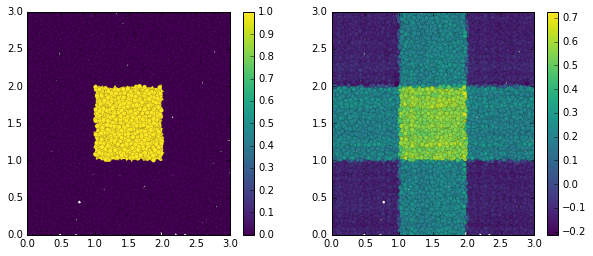

In [61]:
# experimental evidence that NFN is not a universal approximator
# changing number of rules doesn't affect the result in a better way

X = 3*np.random.rand(20000,2)
y = (X[:,0] > 1) & (X[:,0] <= 2) & (X[:,1] > 1) & (X[:,1] <= 2)
nfn = NeoFuzzyNeuron(n_rules = 100)
y_pred = nfn.fit_predict(X, y)

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c = y, lw = 0.1, cmap = 'viridis')
plt.xlim(0,3); plt.ylim(0,3)
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c = y_pred, lw = 0.1, cmap = 'viridis')
plt.xlim(0,3); plt.ylim(0,3)
plt.colorbar()

Now let's talk about practical aspects of NFN applications. 

As was stated before, NFN-AR equivalence equations are ill-defined, as NFN has more degrees of freedom. In practice this also true for many other processes. The error surface is shallow, without a strict global minimum, and without regularization solvers produce inadequate results or even diverge. But even slightest L2-regularization solves the problem.

Another practical thing is training. Many papers propose to use first order gradient methods to minimize MSE loss to tune the NFN, and this can surely be done. But from the description of the model it follows, that after re-indexing it can be represented as linear model with respect to memberships instead of actual input signals:

$$NFN(\vec x) = \sum_{i=1}^{n} \sum_{j=1}^{m} w_{ij} \mu_{ij}(x_i) = \sum_{k=1}^{n \cdot m} w_k \mu_k(x_k)$$

Now we can see, that second order methods are more suited for this problem in general, and it is possible to natively apply plenty of existing linear solvers, which are blazingly fast, highly optimized and well tested. This will save significant amount of time when implementing NFN.

NFN can easily overfit in general. To do so, just increase the number of terms in the inference rules. This will make the underlying grid fine enough to exactly remember each value in the training sample. But overfitting in NFNs happens in a transparent and controllable way, unlike neural nets, for example, and can be easily accounted for. Also, solving a regularized task, as mentioned above, reduces the effect.

(5, 1000)

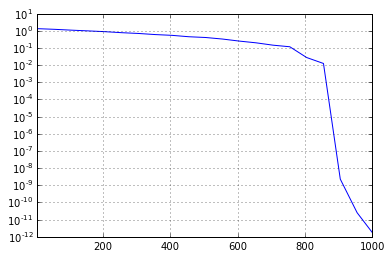

In [76]:
# overfitting example

t = np.linspace(0,10*np.pi,1000)
x = np.sin(t) + np.random.randn(t.size)
D = rollwin(x, 3)
X, y = D[:,:-1], D[:,-1]

def mse(x, y):
    return np.mean(np.square(x - y))

range_rules = np.arange(5, 1050, 50)
    
error = list()
for i in range_rules:
    nfn = NeoFuzzyNeuron(n_rules = i, solver = Ridge(alpha = 1e-8))
    y_pred = nfn.fit_predict(X, y)
    error.append(mse(y, y_pred))

plt.semilogy(range_rules, error)
plt.grid()
plt.xlim(5,1000)

Another topic is membership function form. Initially complementary triangular functions were proposed, but there are also lots of types of membership functions, smooth and non-smooth. Though it might be appealing to use some smooth functions, like gaussian kernels or B-splines, but in practice it seems, that linear approximations provided by triangular MFs are enough. Also triangular functions are much faster to compute. 

One small point is about sparsity. When moving to a linear optimization task, what is minimized is the norm $|| M\vec{w} - \vec{y}||_2$, where matrix $M_{N \times K}$ is composed of memberships of input variables. As one point in the training sample can occupy only one fuzzy set in the input domain and activates only two neighboring MFs, $N (K - 2n)$ of the entries ($n$ being the dimension of the input space) in the matrix $M$ are zeros. So it is possible to apply solvers designed for sparse matrices and also store the data more efficiently.

Last but not least is NFN's interpretability. While being non-linear, it's quite easy to understand NFN's decisions. Each inference rule's membership function can be plotted out, and it's easy to extract dynamics, described by each term in the rule. Fuzzy logic interpretation also can be naturally applied.

One important topic is a selection of a fuzzy partitioning of the input space. Two obvious schemes are uniform grid (notes are placed uniformly) and quantile grid (nodes are places in uniformly spaces quantiles). Latter has more nodes in the regions of higher density. But the knowledge of the domain is very important here. If you know operating regions of the modelled signal, you can gain much better accuracy. There are also methods to dynamically adjust the grid based on data, which are beyond the scope of this article. 

[1] T. Yamakawa, E. Uchino, T. Miki and H. Kusanagi, "A neo fuzzy neuron and its applications to system identification and prediction of the system behavior," Proc. 2nd Int. Conf. on Fuzzy Logic and Neural Networks, pp. 477-483, 1992.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

def mackey_glass(n, a = 0.2, b = 0.1, c = 10, d = 17):   
    x = 1 + np.random.rand(n+d)
    for i in range(d-1, n+d-1):
        x[i+1] = x[i] + a*x[i-d] / (1 + x[i-d]**c) - b*x[i]
    return x[d:]


def generate_process(n):
    y = 20*np.ones(n)
    k = 1
    for i in range(n):   
        if y[i-5] > 10:
            y[i] = y[i-1] - 0.5 
        elif y[i-5] < -10:
            y[i] = y[i-1] + 1
        else:
            y[i] = -1.5*y[i-1]
        y[i] += np.random.randn()
    return y


def generate_switching_process(n):
    y = 0.5*np.ones(n)
    k = 1
    for i in range(n):   
        if 0 < y[i-1] < 1:
            y[i] = 1.1 * y[i-1]
        elif y[i-1] > 1:
            y[i] = -y[i-1]
        elif y[i-1] > -0.1:
            y[i] = -y[i-1]
        else:
            y[i] = 0.9*y[i-1]
    return y


y = generate_switching_process(10000)

T = 1
k = 1
x_train, x_test = tssplit(y, 0.7)
X_train = rollwin(x_train, 2)
X_test = rollwin(x_test, 2)
X_train, y_train = X_train[:,:1], X_train[:,-1]
X_test,  y_test  = X_test[:,:1],  X_test[:,-1]

grid = np.array([[-2.0, -1.5, -0.1001, -0.1, 0.1, 0.9999, 1.0000, 2.0]]).T

nfn = NeoFuzzyNeuron(n_rules = 100, grid = grid, solver = Ridge(alpha = 1e-4, fit_intercept = False))
nfn.fit(X_train, y_train)

y_train_pred = nfn.predict(X_train)
y_test_pred = nfn.predict(X_test)

y_dyn = y_train[:5].tolist()
k = 1000
for i in range(k):
    z = np.array([np.array(y_dyn)[-5:]])
    y_dyn.append(nfn.predict(z)[0])

In [ ]:
#grid         = np.array([[-2.0, -1.5, -0.1, 0.0, 1.0,  1.5, 2.0]]).T
#nfn.weights_ = np.array([[      -0.9, -0.1, 0.1, 1.0, -1.1     ]]).T
#nfn.c_ = 0
y_train_pred = nfn.predict(X_train)

plt.figure(figsize = (16,4))
plt.plot(y_train)
plt.plot(y_train_pred, 'r.-')
# plt.plot(z)

plt.xlim(0,100)

In [ ]:
# nfn.weights_ = np.array([[0.9, -1, 0.0, 1.0, 0]]).T
M = nfn._mfunc(np.vstack([np.linspace(-2,2,1000)]*1).T)
Z = nfn.weights_[None,:,:] * M
Z = Z.sum(axis = 1)
#plt.imshow(nfn.weights_.T[-10:], cmap = 'viridis', interpolation = 'nearest')
#plt.colorbar()
#plt.xticks([0, 1, 2, 3, 4], [-1.5, -0.1, 0.0, 1.0, 1.5]);
plt.plot(np.linspace(-2,2,1000), Z[:,0])

In [ ]:
M.shape